In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from scipy.signal import savgol_filter
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [3]:
def remove_noise(frame, first_par, second_par):
    w_out_noise = savgol_filter(frame["StockValue"], first_par, second_par)
    frame["StockValue"] = w_out_noise
    frame_f = frame[["StockValue"]]
    return frame_f

In [4]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [5]:
def buy_sell_recommendations(new_frame):
    new_frame['rec_1'] = np.where((new_frame['MA_7_50'] > new_frame["MA_50_200"]*0.8)
                                         , "BUY", "SELL")
    new_frame['rec_2'] = np.where((new_frame['MA_14_100'] > new_frame["MA_50_200"]*0.9)
                                         , "BUY", "SELL")
    return new_frame

In [6]:
def get_locations(new_frame):
    loc_first=[]
    for row in range(new_frame.shape[0]-1):

            if new_frame.iloc[row,:].rec_1 == "SELL":
                if new_frame.iloc[row+1,:].rec_1 == "BUY":
                    start = row+1
                    loc_first.append(start)

            if new_frame.iloc[row,:].rec_1 == "BUY":
                if new_frame.iloc[row+1,:].rec_1 == "SELL":
                    end = row+2
                    loc_first.append(end)
                    
    loc_second=[]
    for row in range(new_frame.shape[0]-1):

        if new_frame.iloc[row,:].rec_2 == "SELL":
            if new_frame.iloc[row+1,:].rec_2 == "BUY":
                start = row+1
                loc_second.append(start)

        if new_frame.iloc[row,:].rec_2 == "BUY":
            if new_frame.iloc[row+1,:].rec_2 == "SELL":
                end = row+2
                loc_second.append(end)
                
    return [loc_first, loc_second]

In [7]:
def get_transactions(new_frame, column, locations):
    if new_frame.iloc[0,:][str(column)] == "SELL":
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(0,len(locations),2), range(1,len(locations),2))]
    else:
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(1,len(locations),2), range(2,len(locations),2))]
        transactions.insert(0, [0, locations[0]])

    return transactions

In [8]:
def returns(new_frame, list_of_transactions):
    returns = []
    for transactions in list_of_transactions:
        buy = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[0]
        sell = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[-1]
        ret = (sell-buy)/buy
        returns.append(ret)
    
    return returns

In [9]:
def prod(list_of_all_returns):
    return np.prod([ret+1 for ret in list_of_all_returns]) 

In [10]:
def get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [11]:
def simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    loc_first = get_locations(new_frame)[0]
    loc_second = get_locations(new_frame)[1]
    
    first_transactions = get_transactions(new_frame, "rec_1", loc_first)
    second_transactions = get_transactions(new_frame, "rec_2", loc_second)

    first_returns = returns(new_frame, first_transactions)
    second_returns = returns(new_frame, second_transactions)
    
    first_cum_return = prod(first_returns)
    print(f"Final position of first transactions : {first_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in first_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of first transactions        : {[round(first,3) for first in first_returns]}")
    print(f"Locations of first transactions      : {first_transactions}")
    print("-"*85)
    
    second_cum_return  = prod(second_returns)
    print(f"Final position of second transactions: {second_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in second_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of second transactions       : {[round(second,3) for second in second_returns]}")
    print(f"Locations of second transactions     : {second_transactions}")
    print("-"*85)

    totalReturn = (first_cum_return + second_cum_return) / 2
    print(f"Ultimate position : {totalReturn}")
    
    return totalReturn

In [12]:
start_date = "01-03-2015"
end_date = "25-02-2021"
stock_name = "NATEN"
ma_list=[7,14,50,100,200]
noise_first_par = 51
noise_second_par = 2

In [13]:
simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par)

Final position of first transactions : 1.0
Duration (days) - total length       : 0 - 23
Returns of first transactions        : []
Locations of first transactions      : []
-------------------------------------------------------------------------------------
Final position of second transactions: 1.0
Duration (days) - total length       : 0 - 23
Returns of second transactions       : []
Locations of second transactions     : []
-------------------------------------------------------------------------------------
Ultimate position : 1.0


1.0

In [14]:
frame = get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par)

In [15]:
frame.iloc[32:140,:]

,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,Date,StockValue,rec_1,rec_2


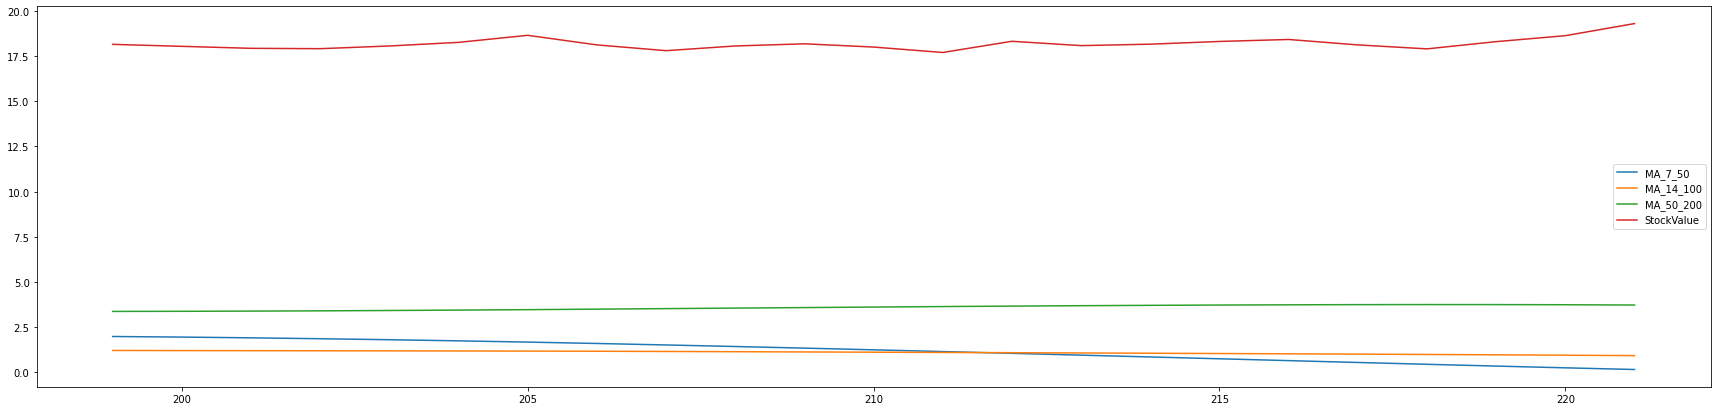

In [16]:
frame[["MA_7_50","MA_14_100","MA_50_200", "StockValue"]].plot(figsize=(30,7))

In [688]:
sm.volatility(stock_name, start_date, end_date)

0.021589698983281665

In [ ]:
## Fonksiyonların nasıl çalıştığını hatırlamak için aşağıda yer alan tutorial incele!

---
### TUTORIAL 

In [42]:
start_date = "01-01-2015"
end_date = "01-01-2021"
stock_name = "BIMAS"
ma_list=[7,14,50,100,200]
noise_first_par = 101
noise_second_par = 2

In [43]:
# scrap et getir --> ihtiyaç hisse senedi değerleri (günlük)
frame = sm.extract_stock_values(start_date, end_date, [stock_name])
frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
frame.to_pickle(stock_name)

In [44]:
# noise temizleme --> yöntem ve parametreler için fonksiyonunun detayına bak
frame = remove_noise(frame, 101, 2)
frame

,StockValue
1,22.649936
3,22.570395
5,22.492430
7,22.416041
9,22.341227
...,...
1605,68.367365
1606,68.874392
1607,69.387643
1608,69.907119


In [45]:
# gürültüsü temizlenmiş hisse senedi verilerinden hareketli ortalamaları hesapla
new_frame = ma_columns(frame, [7,14,50,100,200])
new_frame

,MA_7,MA_14,MA_50,MA_100,MA_200
399,25.323111,25.077697,23.354192,22.273889,21.737592
401,25.373402,25.145479,23.436513,22.313144,21.751858
403,25.418949,25.208420,23.518590,22.352933,21.766690
405,25.461215,25.267719,23.600299,22.393265,21.782105
407,25.500372,25.322419,23.681516,22.434161,21.798072
...,...,...,...,...,...
1605,66.896079,65.273981,58.537089,53.796821,50.000068
1606,67.384433,65.740550,58.891442,54.006278,50.108098
1607,67.879011,66.213343,59.252583,54.219965,50.218616
1608,68.379814,66.692360,59.619899,54.437992,50.331697


In [46]:
# belirli haretketli ortalamalar arasındaki farkı al
new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]

In [47]:
# iki koldan işlem yapılacak. Detayı için buy_sell_recommendation fonskiyonuna bak
new_frame = buy_sell_recommendations(new_frame)
new_frame

,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,rec_1,rec_2
399,25.323111,25.077697,23.354192,22.273889,21.737592,1.968919,2.803807,1.616600,BUY,BUY
401,25.373402,25.145479,23.436513,22.313144,21.751858,1.936890,2.832335,1.684654,BUY,BUY
403,25.418949,25.208420,23.518590,22.352933,21.766690,1.900359,2.855488,1.751900,BUY,BUY
405,25.461215,25.267719,23.600299,22.393265,21.782105,1.860915,2.874454,1.818194,BUY,BUY
407,25.500372,25.322419,23.681516,22.434161,21.798072,1.818856,2.888258,1.883444,SELL,BUY
...,...,...,...,...,...,...,...,...,...,...
1605,66.896079,65.273981,58.537089,53.796821,50.000068,8.358990,11.477160,8.537021,SELL,BUY
1606,67.384433,65.740550,58.891442,54.006278,50.108098,8.492991,11.734272,8.783344,SELL,BUY
1607,67.879011,66.213343,59.252583,54.219965,50.218616,8.626428,11.993378,9.033967,SELL,BUY
1608,68.379814,66.692360,59.619899,54.437992,50.331697,8.759915,12.254368,9.288202,SELL,BUY


In [48]:
# başta scrap edilen ve ham hali hisse senedinin adı ile pickle olarak kaydedilen hisse değerlerini tekrar çağır
#   ve yeni oluşturulan frame ile birleştir.
frame = pd.read_pickle(stock_name)
frame = frame[["HGDG_TARIH", "StockValue"]]
new_frame = new_frame.join(frame)
new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
new_frame

,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,rec_1,rec_2,HGDG_TARIH,StockValue
399,25.323111,25.077697,23.354192,22.273889,21.737592,1.968919,2.803807,1.616600,BUY,BUY,2015-10-16,25.8411
401,25.373402,25.145479,23.436513,22.313144,21.751858,1.936890,2.832335,1.684654,BUY,BUY,2015-10-19,26.2611
403,25.418949,25.208420,23.518590,22.352933,21.766690,1.900359,2.855488,1.751900,BUY,BUY,2015-10-20,26.4600
405,25.461215,25.267719,23.600299,22.393265,21.782105,1.860915,2.874454,1.818194,BUY,BUY,2015-10-21,25.9704
407,25.500372,25.322419,23.681516,22.434161,21.798072,1.818856,2.888258,1.883444,SELL,BUY,2015-10-22,26.1707
...,...,...,...,...,...,...,...,...,...,...,...,...
1605,66.896079,65.273981,58.537089,53.796821,50.000068,8.358990,11.477160,8.537021,SELL,BUY,2020-06-22,68.6500
1606,67.384433,65.740550,58.891442,54.006278,50.108098,8.492991,11.734272,8.783344,SELL,BUY,2020-06-23,69.0000
1607,67.879011,66.213343,59.252583,54.219965,50.218616,8.626428,11.993378,9.033967,SELL,BUY,2020-06-24,70.9500
1608,68.379814,66.692360,59.619899,54.437992,50.331697,8.759915,12.254368,9.288202,SELL,BUY,2020-06-25,70.1500


In [55]:
# Stratejilere göre işlem yapılan tarih aralıkları
loc_first = get_locations(new_frame)[0]
loc_second = get_locations(new_frame)[1]

In [56]:
loc_first

[5, 85, 133, 242, 369, 652, 765, 909, 978, 1139, 1175]

In [57]:
loc_second

[20, 98, 150, 261, 411, 669, 786, 921, 996, 1130]

In [62]:
# transaction günlerini ikili olarak ayıkla
first_transactions = get_transactions(new_frame, "rec_1", loc_first)
second_transactions = get_transactions(new_frame, "rec_2", loc_second)

In [63]:
first_transactions

[[0, 5], [85, 133], [242, 369], [652, 765], [909, 978], [1139, 1175]]

In [64]:
second_transactions

[[0, 20], [98, 150], [261, 411], [669, 786], [921, 996]]

In [65]:
first_returns = returns(new_frame, first_transactions)
second_returns = returns(new_frame, second_transactions)

In [66]:
first_returns

[0.012754874985971928,
 0.24949413008604343,
 0.13398031902785806,
 0.1515718928693612,
 0.34129524396366795,
 0.22276647970153265]

In [67]:
second_returns

[0.01878403009159821,
 0.10092659241167827,
 0.2775515506636741,
 0.2581541788576517,
 0.24179928081072255]